In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os
from tqdm import tqdm
import datetime
import proplot as plot
from netCDF4 import Dataset
from wrf import getvar
%matplotlib inline

plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
import pickle
path = './output/peaks_v1/'
file = [path+'ctrl-peaks-02_45',path+'ncrf36-peaks-02_45',path+'ncrf60-peaks-02_45']

output = []
for i in range(len(file)):
    with open(file[i],'rb') as f:
        output.append(pickle.load(f))

indx_dict = {'CTRLMARIA_peaks':output[0],'NCRF36MARIA_peaks':output[1],'NCRF60MARIA_peaks':output[1]}

#### Test James' wrfout

In [3]:
path = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/'
file = sorted(glob.glob(path+'wrfout*'))

In [4]:
test = xr.open_dataset(file[0])

In [5]:
test

<xarray.Dataset>
Dimensions:                (Time: 1, south_north: 750, west_east: 1248, bottom_top: 54, bottom_top_stag: 55, soil_layers_stag: 5, west_east_stag: 1249, south_north_stag: 751)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top, bottom_top_stag, soil_layers_stag, west_east_stag, south_north_stag
Data variables: (12/166)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/119)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2017-09-14_12:00:00
    SIMULATION_START_DATE:           2017-09-14_12:00:00
    WEST-EAST_GRID_DIMENSION:        1249
    SOUTH-NORTH_GRID_DIMENSION:      751
    BOTTOM-TOP_GRID_DIMENSION:       55
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      -1
    ETAC:                            0.0

#### Read in Vapor Mixing Ratio

In [3]:
origin_path = '/scratch/06040/tg853394/tc/output/redux/maria/'
#Function####################################################
def read_some_azimuth_fields(fileloc=None,fieldname=None):
    dict_name = {}
    for inx,obj in enumerate(fileloc):
        field_read = xr.open_dataset(obj)
        dict_name[fieldname[inx]] = field_read
    return dict_name

def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values
#############################################################
ctrlvar_dict = read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_QVAPOR_0-144hr.nc'],fieldname=['QVAPOR'])
ncrf36var_dict = read_some_azimuth_fields(fileloc=[origin_path+'ncrf_36h/azim_QVAPOR_36-144hr.nc'],fieldname=['QVAPOR'])
ncrf60var_dict = read_some_azimuth_fields(fileloc=[origin_path+'ncrf_60h/azim_QVAPOR_60-144hr.nc'],fieldname=['QVAPOR'])
# Azimuth: 125:225; 230:325

#from copy import deepcopy
#QVhigh,QVlow = [],[]

#for indx,obj in enumerate(indx_dict['HIGHIR_MARIA']):
#    testa_org = deepcopy(dataQV.QVAPOR[int(obj),:,:])
#    QVhigh.append(testa_org)
#del testa_org

#for indx,obj in enumerate(indx_dict['LOWIR_MARIA']):
#    testa_org = deepcopy(dataQV.QVAPOR[int(obj),:,:])
#    QVlow.append(testa_org)
#del testa_org

In [18]:
# Target temporal period
#####################################################################################################################################################
time2_ctrl,time45_ctrl = nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].time/24, 2),nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].time/24, 4.5)
time2_ncrf36,time45_ncrf36 = nearest_index(ncrf36var_dict['QVAPOR']['QVAPOR'].time/24, 2),nearest_index(ncrf36var_dict['QVAPOR']['QVAPOR'].time/24, 4.5)
time2_ncrf60,time45_ncrf60 = nearest_index(ncrf60var_dict['QVAPOR']['QVAPOR'].time/24, 2),nearest_index(ncrf60var_dict['QVAPOR']['QVAPOR'].time/24, 4.5)

target_i = 3 #4 00-12 18 Sep
target_ctrl,target_ncrf36,target_ncrf60 = time2_ctrl+indx_dict['CTRLMARIA_peaks'][target_i],time2_ncrf36+indx_dict['NCRF36MARIA_peaks'][target_i],\
time2_ncrf60+indx_dict['NCRF60MARIA_peaks'][target_i-2]

### Analyze

In [19]:
#def output_closest_index(array=None,target=None):
#    return np.abs(array-target).argmin()
qv_extct_p4_ctrl = ctrlvar_dict['QVAPOR']['QVAPOR'][target_ctrl-1-12:target_ctrl-1,:,:,:]
qv_extct_p4_ncrf36 = ncrf36var_dict['QVAPOR']['QVAPOR'][target_ncrf36-1-12:target_ncrf36-1,:,:,:]
qv_extct_p4_ncrf60 = ncrf60var_dict['QVAPOR']['QVAPOR'][target_ncrf60-1-12:target_ncrf60-1,:,:,:]

##### I. Upshear-left

In [20]:
path_coor = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/post/U.nc'
coor = xr.open_dataset(path_coor)

# UL
a18,a288=(nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,18.22),nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,288.22))
r0,r200=(nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].radius,0),nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].radius,200))
r300,r500=(nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].radius,300),nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].radius,500))

In [21]:
#288.22,18.22
# UL
a18,a288=(nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,18.22),
          nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,288.22))
r0,r200=(nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].radius,0),
           nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].radius,200))
r300,r500=(nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].radius,300),
           nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].radius,500))
ctrl_qv_ul = np.concatenate(((qv_extct_p4_ctrl)[:,:,int(a288):-1,:],\
                (qv_extct_p4_ctrl)[:,:,0:int(a18),:]),axis=2)
ncrf36_qv_ul = np.concatenate(((qv_extct_p4_ncrf36)[:,:,int(a288):-1,:],\
                (qv_extct_p4_ncrf36)[:,:,0:int(a18),:]),axis=2)
ncrf60_qv_ul = np.concatenate(((qv_extct_p4_ncrf60)[:,:,int(a288):-1,:],\
                (qv_extct_p4_ncrf60)[:,:,0:int(a18),:]),axis=2)

In [22]:
QVctrl_uliprof = np.nanmean((ctrl_qv_ul)[:,:,:,int(r0):int(r200)],axis=(0,2,3))
QVncrf36_uliprof = np.nanmean((ncrf36_qv_ul)[:,:,:,int(r0):int(r200)],axis=(0,2,3))
QVncrf60_uliprof = np.nanmean((ncrf60_qv_ul)[:,:,:,int(r0):int(r200)],axis=(0,2,3))
QVctrl_uli25,QVctrl_uli75=np.nanpercentile((ctrl_qv_ul)[:,:,:,int(r0):int(r200)],q=[25,75],axis=(0,2,3))
QVncrf36_uli25,QVncrf36_uli75=np.nanpercentile((ncrf36_qv_ul)[:,:,:,int(r0):int(r200)],q=[25,75],axis=(0,2,3))
QVncrf60_uli25,QVncrf60_uli75=np.nanpercentile((ncrf60_qv_ul)[:,:,:,int(r0):int(r200)],q=[25,75],axis=(0,2,3))

# Outer
QVctrl_uloprof = np.nanmean((ctrl_qv_ul)[:,:,:,int(r300):int(r500)],axis=(0,2,3))
QVncrf36_uloprof = np.nanmean((ncrf36_qv_ul)[:,:,:,int(r300):int(r500)],axis=(0,2,3))
QVncrf60_uloprof = np.nanmean((ncrf60_qv_ul)[:,:,:,int(r300):int(r500)],axis=(0,2,3))
QVctrl_ulo25,QVctrl_ulo75=np.nanpercentile((ctrl_qv_ul)[:,:,:,int(r300):int(r500)],q=[25,75],axis=(0,2,3))
QVncrf36_ulo25,QVncrf36_ulo75=np.nanpercentile((ncrf36_qv_ul)[:,:,:,int(r300):int(r500)],q=[25,75],axis=(0,2,3))
QVncrf60_ulo25,QVncrf60_ulo75=np.nanpercentile((ncrf60_qv_ul)[:,:,:,int(r300):int(r500)],q=[25,75],axis=(0,2,3))

In [23]:
import metpy.calc as mpcalc
from metpy.units import units
height = np.asarray(mpcalc.pressure_to_height_std(units.Quantity(coor.pres.data,'hPa')))

##### II. Downshear left

In [24]:
a18,a108=nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,18.22),\
nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,108.22)

QVctrl_dliprof = np.nanmean((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                         int(r0):int(r200)],axis=(0,2,3))
QVncrf36_dliprof = np.nanmean((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                             int(r0):int(r200)],axis=(0,2,3))
QVncrf60_dliprof = np.nanmean((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                             int(r0):int(r200)],axis=(0,2,3))
QVctrl_dli25,QVctrl_dli75=np.nanpercentile((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                                        int(r0):int(r200)],q=[25,75],axis=(0,2,3))
QVncrf36_dli25,QVncrf36_dli75=np.nanpercentile((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                                              int(r0):int(r200)],q=[25,75],axis=(0,2,3))
QVncrf60_dli25,QVncrf60_dli75=np.nanpercentile((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                                              int(r0):int(r200)],q=[25,75],axis=(0,2,3))

# Outer
QVctrl_dloprof = np.nanmean((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                         int(r300):int(r500)],axis=(0,2,3))
QVncrf36_dloprof = np.nanmean((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                             int(r300):int(r500)],axis=(0,2,3))
QVncrf60_dloprof = np.nanmean((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                             int(r300):int(r500)],axis=(0,2,3))
QVctrl_dlo25,QVctrl_dlo75=np.nanpercentile((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                                        int(r300):int(r500)],q=[25,75],axis=(0,2,3))
QVncrf36_dlo25,QVncrf36_dlo75=np.nanpercentile((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                                              int(r300):int(r500)],q=[25,75],axis=(0,2,3))
QVncrf60_dlo25,QVncrf60_dlo75=np.nanpercentile((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                                              int(r300):int(r500)],q=[25,75],axis=(0,2,3))

##### III. Downshear right

In [25]:
a18,a108=nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,108.22),\
nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,198.22)

QVctrl_driprof = np.nanmean((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                         int(r0):int(r200)],axis=(0,2,3))
QVncrf36_driprof = np.nanmean((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                             int(r0):int(r200)],axis=(0,2,3))
QVncrf60_driprof = np.nanmean((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                             int(r0):int(r200)],axis=(0,2,3))
QVctrl_dri25,QVctrl_dri75=np.nanpercentile((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                                        int(r0):int(r200)],q=[25,75],axis=(0,2,3))
QVncrf36_dri25,QVncrf36_dri75=np.nanpercentile((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                                              int(r0):int(r200)],q=[25,75],axis=(0,2,3))
QVncrf60_dri25,QVncrf60_dri75=np.nanpercentile((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                                              int(r0):int(r200)],q=[25,75],axis=(0,2,3))

# Outer
QVctrl_droprof = np.nanmean((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                         int(r300):int(r500)],axis=(0,2,3))
QVncrf36_droprof = np.nanmean((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                             int(r300):int(r500)],axis=(0,2,3))
QVncrf60_droprof = np.nanmean((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                             int(r300):int(r500)],axis=(0,2,3))
QVctrl_dro25,QVctrl_dro75=np.nanpercentile((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                                        int(r300):int(r500)],q=[25,75],axis=(0,2,3))
QVncrf36_dro25,QVncrf36_dro75=np.nanpercentile((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                                              int(r300):int(r500)],q=[25,75],axis=(0,2,3))
QVncrf60_dro25,QVncrf60_dro75=np.nanpercentile((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                                              int(r300):int(r500)],q=[25,75],axis=(0,2,3))

##### IV. Upshear right

In [26]:
a18,a108=nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,198.22),\
nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,288.22)

QVctrl_uriprof = np.nanmean((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                         int(r0):int(r200)],axis=(0,2,3))
QVncrf36_uriprof = np.nanmean((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                             int(r0):int(r200)],axis=(0,2,3))
QVncrf60_uriprof = np.nanmean((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                             int(r0):int(r200)],axis=(0,2,3))
QVctrl_uri25,QVctrl_uri75=np.nanpercentile((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                                        int(r0):int(r200)],q=[25,75],axis=(0,2,3))
QVncrf36_uri25,QVncrf36_uri75=np.nanpercentile((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                                              int(r0):int(r200)],q=[25,75],axis=(0,2,3))
QVncrf60_uri25,QVncrf60_uri75=np.nanpercentile((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                                              int(r0):int(r200)],q=[25,75],axis=(0,2,3))

# Outer
QVctrl_uroprof = np.nanmean((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                         int(r300):int(r500)],axis=(0,2,3))
QVncrf36_uroprof = np.nanmean((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                             int(r300):int(r500)],axis=(0,2,3))
QVncrf60_uroprof = np.nanmean((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                             int(r300):int(r500)],axis=(0,2,3))
QVctrl_uro25,QVctrl_uro75=np.nanpercentile((qv_extct_p4_ctrl)[:,:,int(a18):int(a108),
                                                        int(r300):int(r500)],q=[25,75],axis=(0,2,3))
QVncrf36_uro25,QVncrf36_uro75=np.nanpercentile((qv_extct_p4_ncrf36)[:,:,int(a18):int(a108),
                                                              int(r300):int(r500)],q=[25,75],axis=(0,2,3))
QVncrf60_uro25,QVncrf60_uro75=np.nanpercentile((qv_extct_p4_ncrf60)[:,:,int(a18):int(a108),
                                                              int(r300):int(r500)],q=[25,75],axis=(0,2,3))

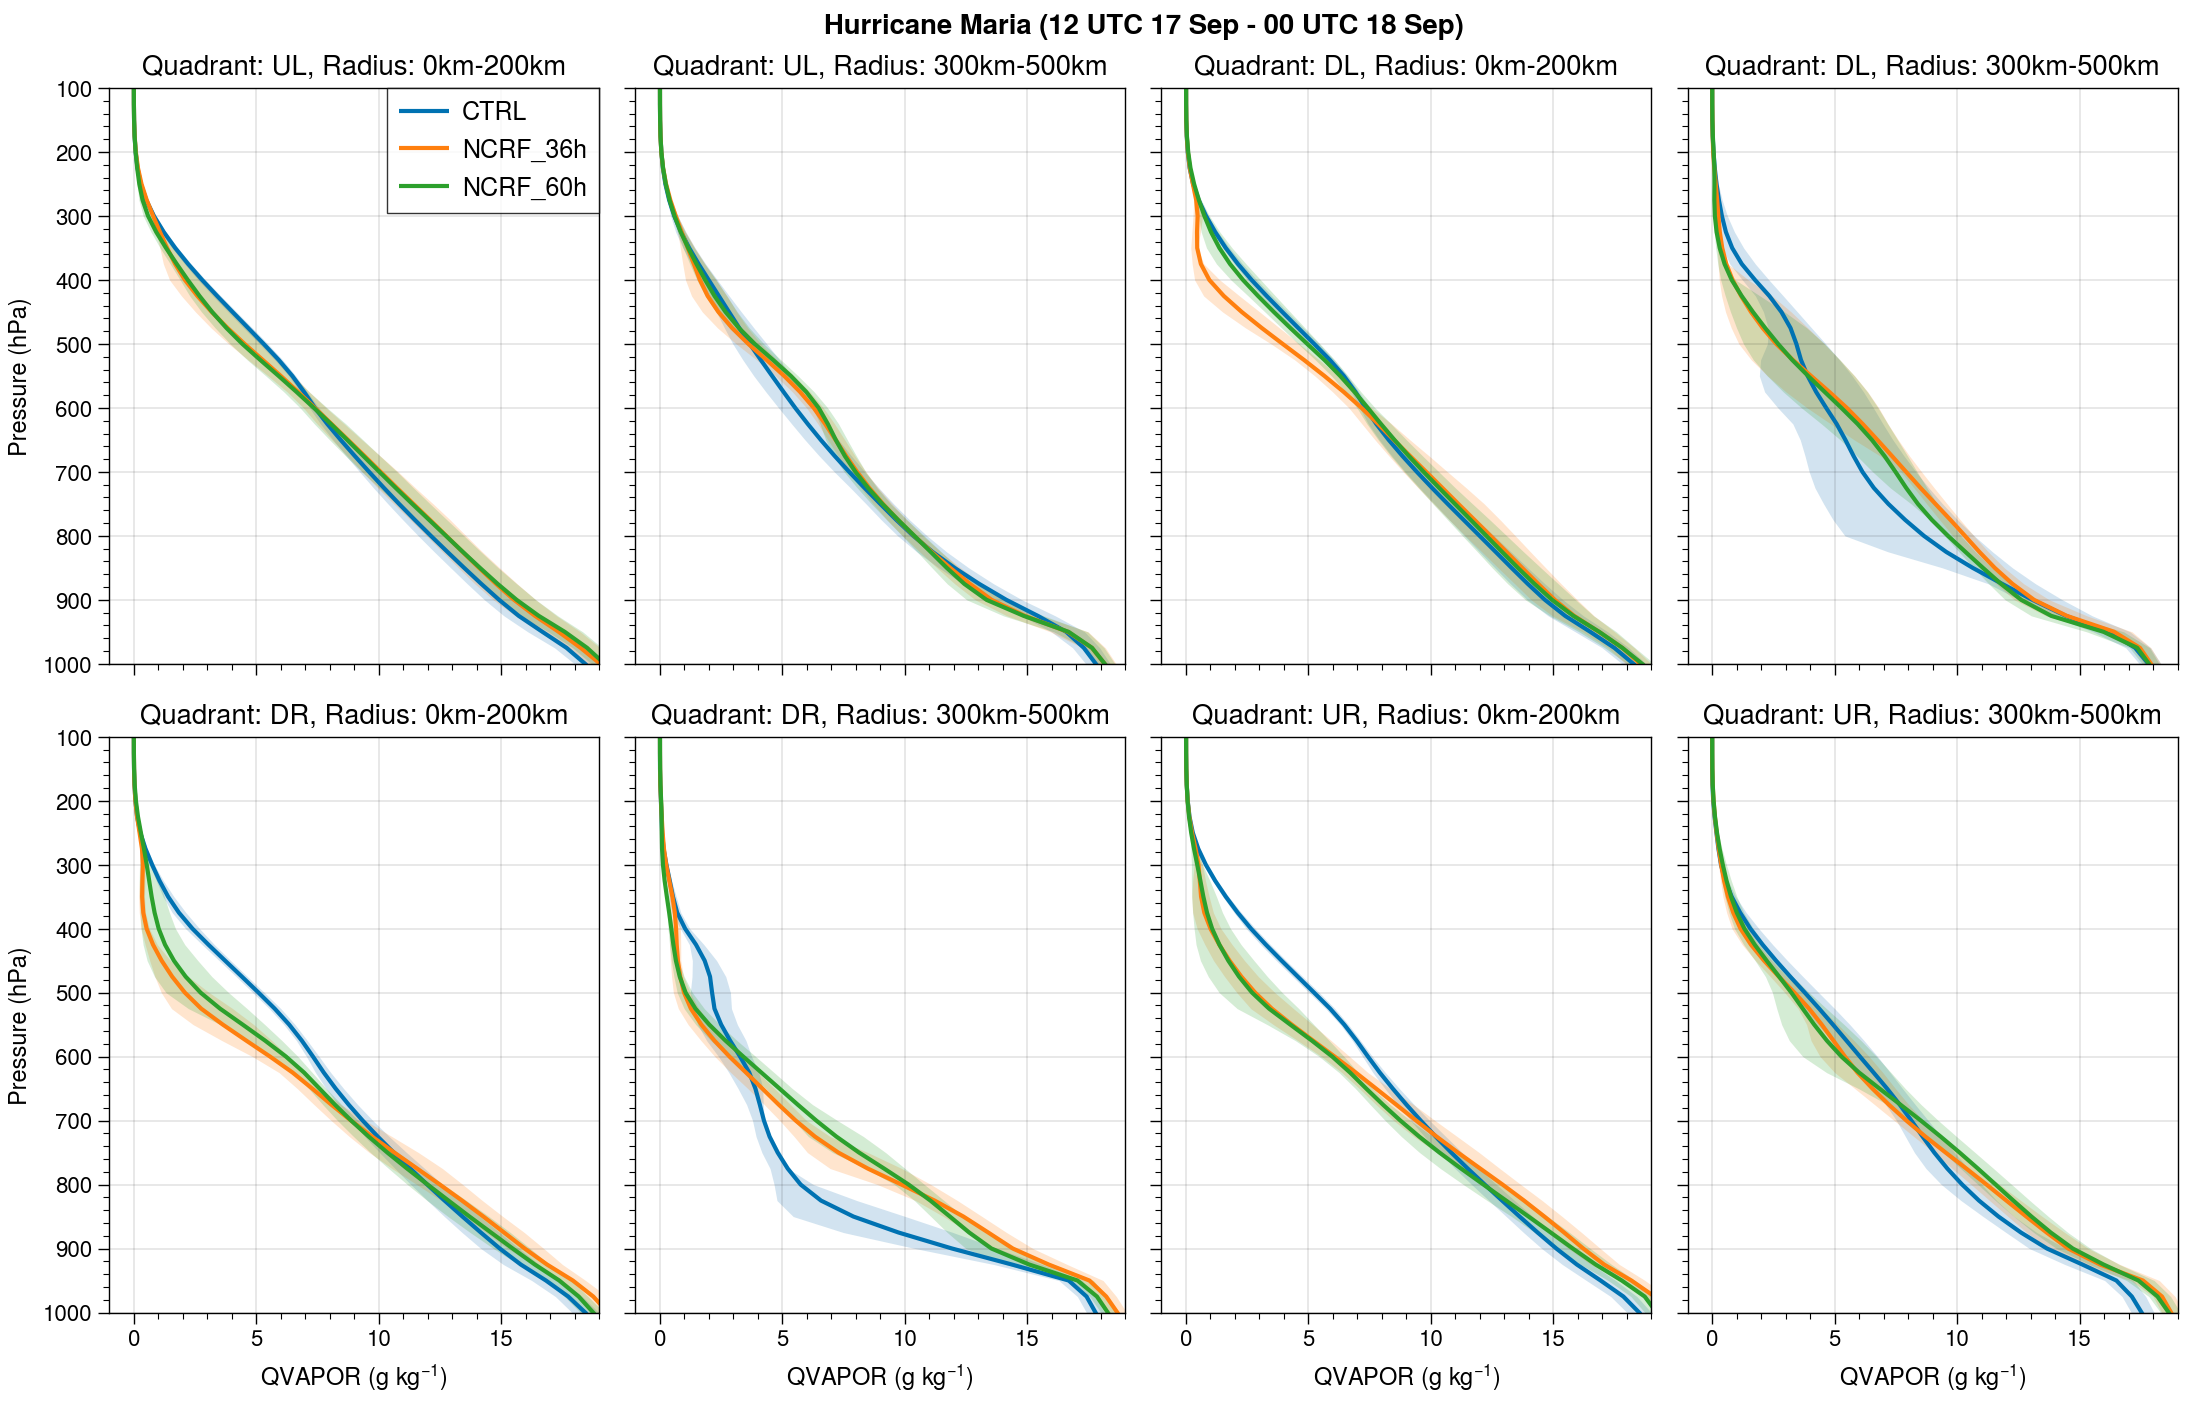

In [27]:
fig,axs = plot.subplots(ncols=4,nrows=2,axwidth=2.45,refaspect=0.851,span=False)
# UL
axs[0].plot(QVctrl_uliprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[0].fill_betweenx(coor.pres,QVctrl_uli25*1000,QVctrl_uli75*1000,alpha=0.2,color='#1f77b4')
axs[0].plot(QVncrf36_uliprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[0].fill_betweenx(coor.pres,QVncrf36_uli25*1000,QVncrf36_uli75*1000,alpha=0.2,color='#ff7f0e')
axs[0].plot(QVncrf60_uliprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[0].fill_betweenx(coor.pres,QVncrf60_uli25*1000,QVncrf60_uli75*1000,alpha=0.2,color='#2ca02c')
axs[0].format(title='Quadrant: UL, Radius: 0km-200km')
axs[0].legend(loc='ur',ncols=1)
axs[1].plot(QVctrl_uloprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[1].fill_betweenx(coor.pres,QVctrl_ulo25*1000,QVctrl_ulo75*1000,alpha=0.2,color='#1f77b4')
axs[1].plot(QVncrf36_uloprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[1].fill_betweenx(coor.pres,QVncrf36_ulo25*1000,QVncrf36_ulo75*1000,alpha=0.2,color='#ff7f0e')
axs[1].plot(QVncrf60_uloprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[1].fill_betweenx(coor.pres,QVncrf60_ulo25*1000,QVncrf60_ulo75*1000,alpha=0.2,color='#2ca02c')
axs[1].format(title='Quadrant: UL, Radius: 300km-500km')

#DL
axs[2].plot(QVctrl_dliprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[2].fill_betweenx(coor.pres,QVctrl_dli25*1000,QVctrl_dli75*1000,alpha=0.2,color='#1f77b4')
axs[2].plot(QVncrf36_dliprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[2].fill_betweenx(coor.pres,QVncrf36_dli25*1000,QVncrf36_dli75*1000,alpha=0.2,color='#ff7f0e')
axs[2].plot(QVncrf60_dliprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[2].fill_betweenx(coor.pres,QVncrf60_dli25*1000,QVncrf60_dli75*1000,alpha=0.2,color='#2ca02c')
axs[2].format(title='Quadrant: DL, Radius: 0km-200km')
axs[3].plot(QVctrl_dloprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[3].fill_betweenx(coor.pres,QVctrl_dlo25*1000,QVctrl_dlo75*1000,alpha=0.2,color='#1f77b4')
axs[3].plot(QVncrf36_dloprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[3].fill_betweenx(coor.pres,QVncrf36_dlo25*1000,QVncrf36_dlo75*1000,alpha=0.2,color='#ff7f0e')
axs[3].plot(QVncrf60_dloprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[3].fill_betweenx(coor.pres,QVncrf60_dlo25*1000,QVncrf60_dlo75*1000,alpha=0.2,color='#2ca02c')
axs[3].format(title='Quadrant: DL, Radius: 300km-500km')

#DR
axs[4].plot(QVctrl_driprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[4].fill_betweenx(coor.pres,QVctrl_dri25*1000,QVctrl_dri75*1000,alpha=0.2,color='#1f77b4')
axs[4].plot(QVncrf36_driprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[4].fill_betweenx(coor.pres,QVncrf36_dri25*1000,QVncrf36_dri75*1000,alpha=0.2,color='#ff7f0e')
axs[4].plot(QVncrf60_driprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[4].fill_betweenx(coor.pres,QVncrf60_dri25*1000,QVncrf60_dri75*1000,alpha=0.2,color='#2ca02c')
axs[4].format(title='Quadrant: DR, Radius: 0km-200km')
axs[5].plot(QVctrl_droprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[5].fill_betweenx(coor.pres,QVctrl_dro25*1000,QVctrl_dro75*1000,alpha=0.2,color='#1f77b4')
axs[5].plot(QVncrf36_droprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[5].fill_betweenx(coor.pres,QVncrf36_dro25*1000,QVncrf36_dro75*1000,alpha=0.2,color='#ff7f0e')
axs[5].plot(QVncrf60_droprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[5].fill_betweenx(coor.pres,QVncrf60_dro25*1000,QVncrf60_dro75*1000,alpha=0.2,color='#2ca02c')
axs[5].format(title='Quadrant: DR, Radius: 300km-500km')

#UR
axs[6].plot(QVctrl_uriprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[6].fill_betweenx(coor.pres,QVctrl_uri25*1000,QVctrl_uri75*1000,alpha=0.2,color='#1f77b4')
axs[6].plot(QVncrf36_uriprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[6].fill_betweenx(coor.pres,QVncrf36_uri25*1000,QVncrf36_uri75*1000,alpha=0.2,color='#ff7f0e')
axs[6].plot(QVncrf60_uriprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[6].fill_betweenx(coor.pres,QVncrf60_uri25*1000,QVncrf60_uri75*1000,alpha=0.2,color='#2ca02c')
axs[6].format(title='Quadrant: UR, Radius: 0km-200km')
axs[7].plot(QVctrl_uroprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[7].fill_betweenx(coor.pres,QVctrl_uro25*1000,QVctrl_uro75*1000,alpha=0.2,color='#1f77b4')
axs[7].plot(QVncrf36_uroprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[7].fill_betweenx(coor.pres,QVncrf36_uro25*1000,QVncrf36_uro75*1000,alpha=0.2,color='#ff7f0e')
axs[7].plot(QVncrf60_uroprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[7].fill_betweenx(coor.pres,QVncrf60_uro25*1000,QVncrf60_uro75*1000,alpha=0.2,color='#2ca02c')
axs[7].format(title='Quadrant: UR, Radius: 300km-500km')

axs.format(xlabel='QVAPOR (g kg$^{-1}$)',ylabel='Pressure (hPa)',\
           suptitle='Hurricane Maria (12 UTC 17 Sep - 00 UTC 18 Sep)',xlim=[-1,19],ylim=[1000,100])
for axisobj in axs:
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
plt.show()

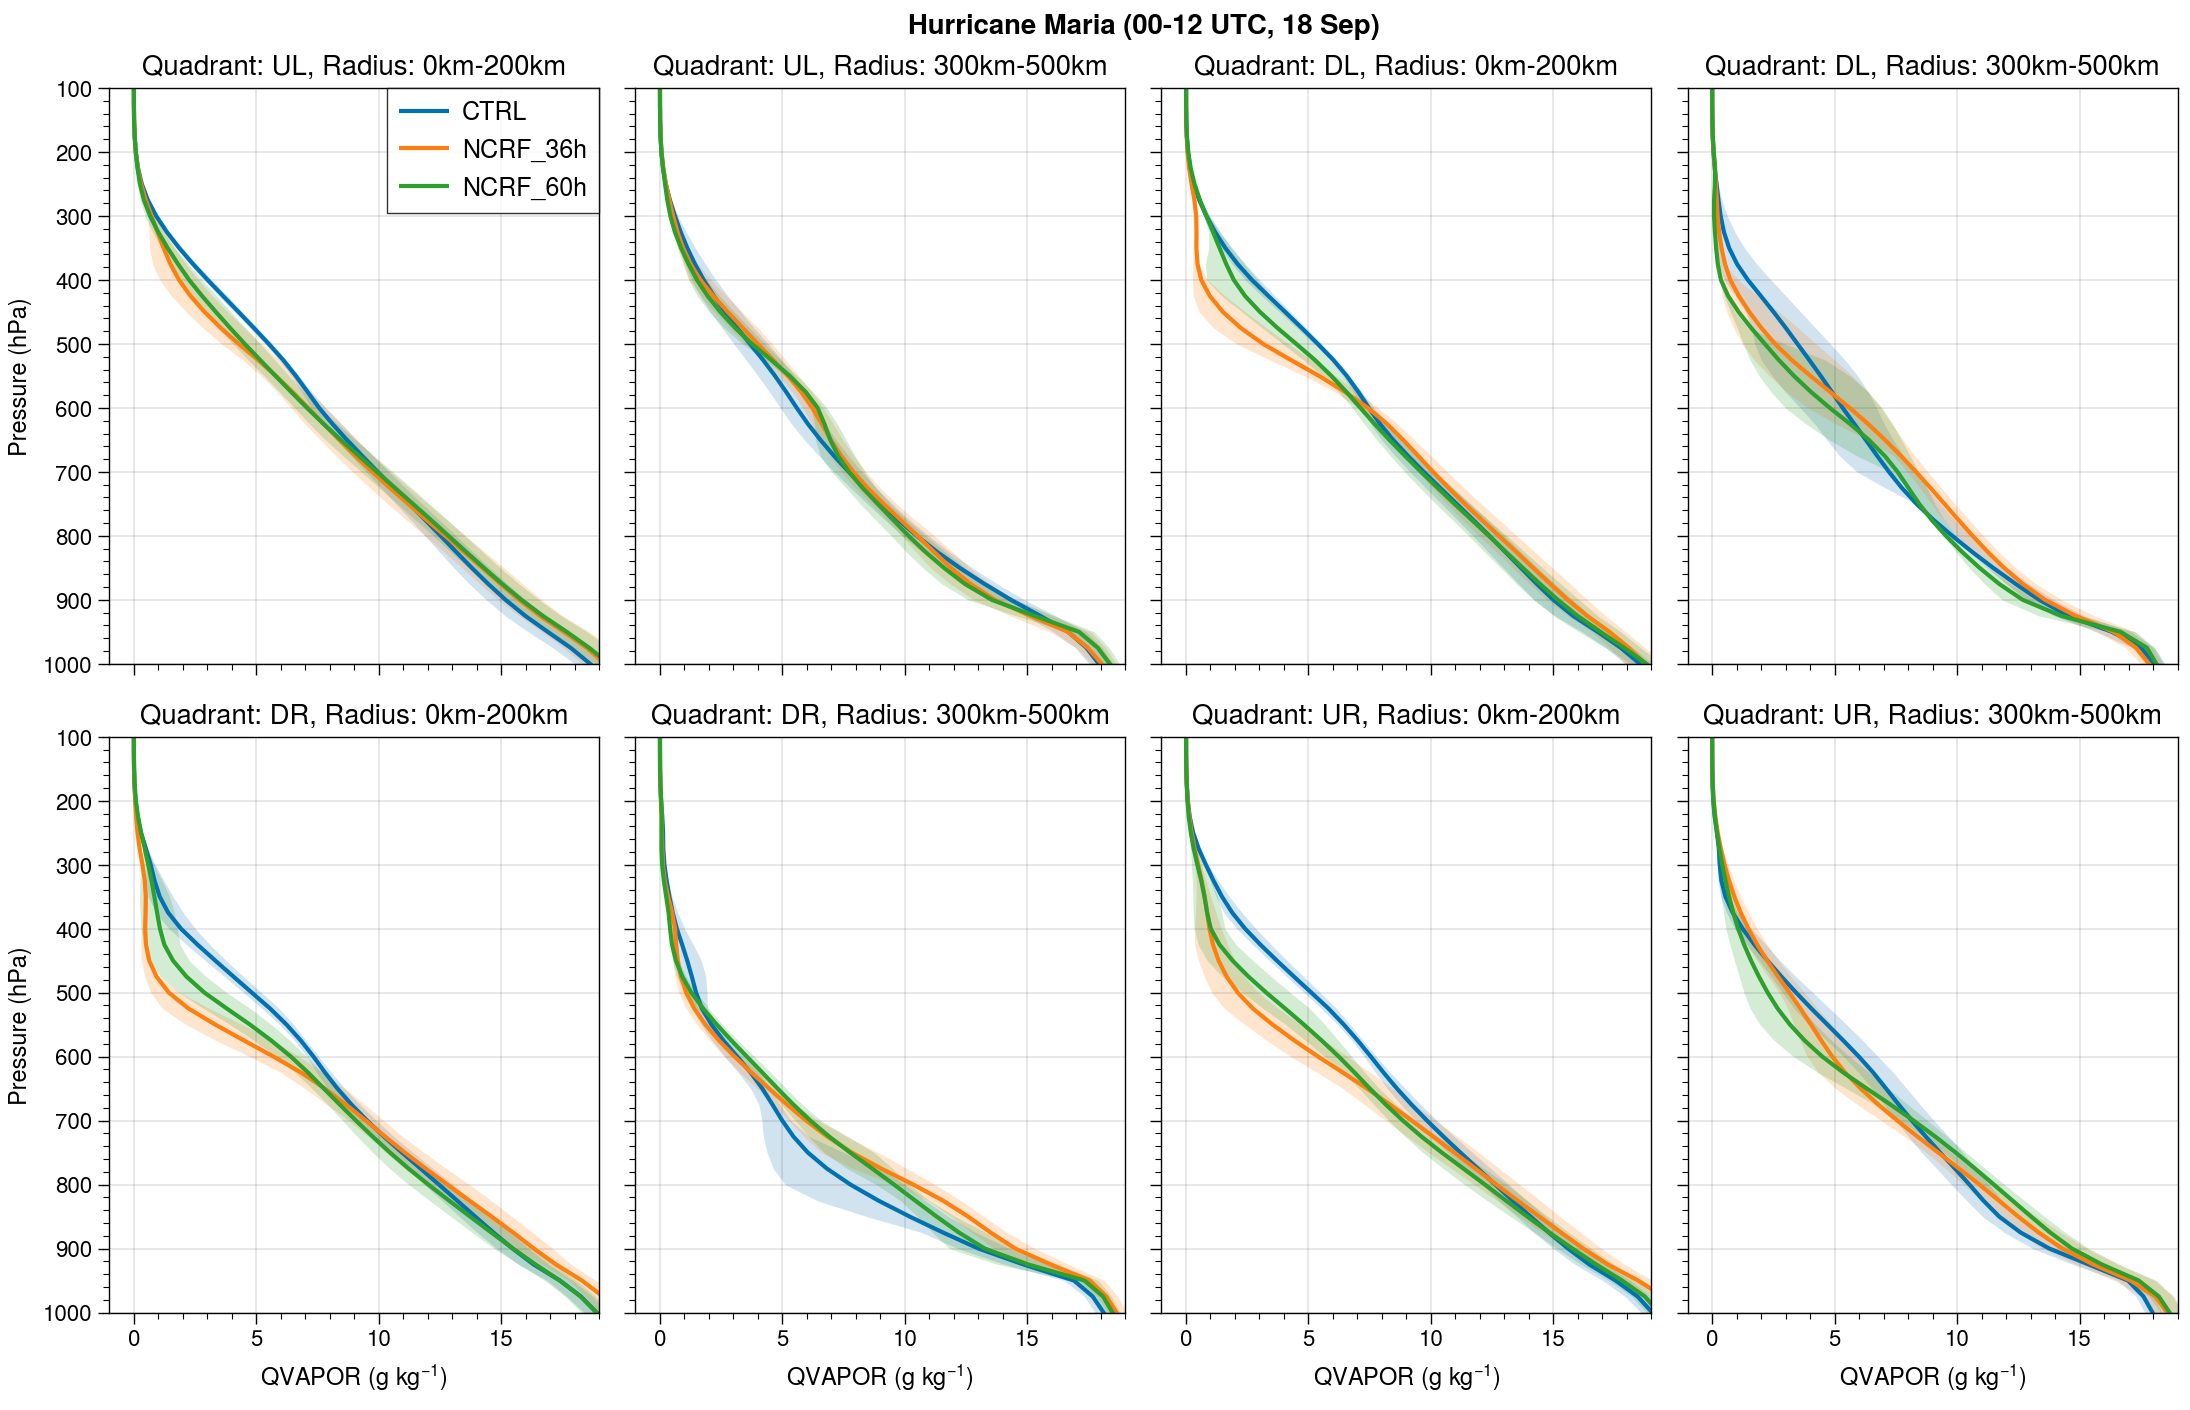

In [17]:
fig,axs = plot.subplots(ncols=4,nrows=2,axwidth=2.45,refaspect=0.851,span=False)
# UL
axs[0].plot(QVctrl_uliprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[0].fill_betweenx(coor.pres,QVctrl_uli25*1000,QVctrl_uli75*1000,alpha=0.2,color='#1f77b4')
axs[0].plot(QVncrf36_uliprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[0].fill_betweenx(coor.pres,QVncrf36_uli25*1000,QVncrf36_uli75*1000,alpha=0.2,color='#ff7f0e')
axs[0].plot(QVncrf60_uliprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[0].fill_betweenx(coor.pres,QVncrf60_uli25*1000,QVncrf60_uli75*1000,alpha=0.2,color='#2ca02c')
axs[0].format(title='Quadrant: UL, Radius: 0km-200km')
axs[0].legend(loc='ur',ncols=1)
axs[1].plot(QVctrl_uloprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[1].fill_betweenx(coor.pres,QVctrl_ulo25*1000,QVctrl_ulo75*1000,alpha=0.2,color='#1f77b4')
axs[1].plot(QVncrf36_uloprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[1].fill_betweenx(coor.pres,QVncrf36_ulo25*1000,QVncrf36_ulo75*1000,alpha=0.2,color='#ff7f0e')
axs[1].plot(QVncrf60_uloprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[1].fill_betweenx(coor.pres,QVncrf60_ulo25*1000,QVncrf60_ulo75*1000,alpha=0.2,color='#2ca02c')
axs[1].format(title='Quadrant: UL, Radius: 300km-500km')

#DL
axs[2].plot(QVctrl_dliprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[2].fill_betweenx(coor.pres,QVctrl_dli25*1000,QVctrl_dli75*1000,alpha=0.2,color='#1f77b4')
axs[2].plot(QVncrf36_dliprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[2].fill_betweenx(coor.pres,QVncrf36_dli25*1000,QVncrf36_dli75*1000,alpha=0.2,color='#ff7f0e')
axs[2].plot(QVncrf60_dliprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[2].fill_betweenx(coor.pres,QVncrf60_dli25*1000,QVncrf60_dli75*1000,alpha=0.2,color='#2ca02c')
axs[2].format(title='Quadrant: DL, Radius: 0km-200km')
axs[3].plot(QVctrl_dloprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[3].fill_betweenx(coor.pres,QVctrl_dlo25*1000,QVctrl_dlo75*1000,alpha=0.2,color='#1f77b4')
axs[3].plot(QVncrf36_dloprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[3].fill_betweenx(coor.pres,QVncrf36_dlo25*1000,QVncrf36_dlo75*1000,alpha=0.2,color='#ff7f0e')
axs[3].plot(QVncrf60_dloprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[3].fill_betweenx(coor.pres,QVncrf60_dlo25*1000,QVncrf60_dlo75*1000,alpha=0.2,color='#2ca02c')
axs[3].format(title='Quadrant: DL, Radius: 300km-500km')

#DR
axs[4].plot(QVctrl_driprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[4].fill_betweenx(coor.pres,QVctrl_dri25*1000,QVctrl_dri75*1000,alpha=0.2,color='#1f77b4')
axs[4].plot(QVncrf36_driprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[4].fill_betweenx(coor.pres,QVncrf36_dri25*1000,QVncrf36_dri75*1000,alpha=0.2,color='#ff7f0e')
axs[4].plot(QVncrf60_driprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[4].fill_betweenx(coor.pres,QVncrf60_dri25*1000,QVncrf60_dri75*1000,alpha=0.2,color='#2ca02c')
axs[4].format(title='Quadrant: DR, Radius: 0km-200km')
axs[5].plot(QVctrl_droprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[5].fill_betweenx(coor.pres,QVctrl_dro25*1000,QVctrl_dro75*1000,alpha=0.2,color='#1f77b4')
axs[5].plot(QVncrf36_droprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[5].fill_betweenx(coor.pres,QVncrf36_dro25*1000,QVncrf36_dro75*1000,alpha=0.2,color='#ff7f0e')
axs[5].plot(QVncrf60_droprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[5].fill_betweenx(coor.pres,QVncrf60_dro25*1000,QVncrf60_dro75*1000,alpha=0.2,color='#2ca02c')
axs[5].format(title='Quadrant: DR, Radius: 300km-500km')

#UR
axs[6].plot(QVctrl_uriprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[6].fill_betweenx(coor.pres,QVctrl_uri25*1000,QVctrl_uri75*1000,alpha=0.2,color='#1f77b4')
axs[6].plot(QVncrf36_uriprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[6].fill_betweenx(coor.pres,QVncrf36_uri25*1000,QVncrf36_uri75*1000,alpha=0.2,color='#ff7f0e')
axs[6].plot(QVncrf60_uriprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[6].fill_betweenx(coor.pres,QVncrf60_uri25*1000,QVncrf60_uri75*1000,alpha=0.2,color='#2ca02c')
axs[6].format(title='Quadrant: UR, Radius: 0km-200km')
axs[7].plot(QVctrl_uroprof*1000,coor.pres,lw=1.5,label='CTRL')
axs[7].fill_betweenx(coor.pres,QVctrl_uro25*1000,QVctrl_uro75*1000,alpha=0.2,color='#1f77b4')
axs[7].plot(QVncrf36_uroprof*1000,coor.pres,lw=1.5,color='#ff7f0e',label='NCRF_36h')
axs[7].fill_betweenx(coor.pres,QVncrf36_uro25*1000,QVncrf36_uro75*1000,alpha=0.2,color='#ff7f0e')
axs[7].plot(QVncrf60_uroprof*1000,coor.pres,lw=1.5,color='#2ca02c',label='NCRF_60h')
axs[7].fill_betweenx(coor.pres,QVncrf60_uro25*1000,QVncrf60_uro75*1000,alpha=0.2,color='#2ca02c')
axs[7].format(title='Quadrant: UR, Radius: 300km-500km')

axs.format(xlabel='QVAPOR (g kg$^{-1}$)',ylabel='Pressure (hPa)',suptitle='Hurricane Maria (00-12 UTC, 18 Sep)',xlim=[-1,19],ylim=[1000,100])
for axisobj in axs:
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
plt.show()

In [27]:
a180,a350=(nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,180),nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].azmiuth,250))
r300,r500=(nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].radius,300),nearest_index(ctrlvar_dict['QVAPOR']['QVAPOR'].radius,500))